## Data processing

### Include only position players appearing after 1975

In [2]:
import pandas as pd
df = pd.read_csv('bsb_ref.csv')
df = df.fillna(df.mean())     
df = df[df.year_ID >= 1975]    # drop rows before 1975
df = df[df.pitcher == 'N']     # drop pitchers

# player MLB ID => player name
playerNameToID = {row['mlb_ID']: row['name_common'] for __, row in df.iterrows()}

### Filter out players who appeared in 2013-2017

In [3]:
players = list(set(df.name_common))     # list of all players
metrics = [col for col in df.columns if df[col].dtype != 'object']    # should have 41 things
years = [2012, 2013, 2014, 2015, 2016, 2017]

In [4]:
df_X_2012 = pd.DataFrame(columns=df.columns)
df_X_2013 = pd.DataFrame(columns=df.columns)
df_X_2014 = pd.DataFrame(columns=df.columns)
df_X_2015 = pd.DataFrame(columns=df.columns)
df_X_2016 = pd.DataFrame(columns=df.columns)
df_X_2017 = pd.DataFrame(columns=df.columns)

# only consider players that appeared in 'years_appeared_in'
def eligible_player(player, years_appeared_in, years_of_interest):
    return set(years_of_interest).issubset(years_appeared_in)

for player in players:
    player_rows = df[df.name_common == player]
    if not eligible_player(player, player_rows.year_ID.values, years):
        continue
    df_X_2012 = df_X_2012.append(player_rows[player_rows.year_ID == 2012].head(1))
    df_X_2013 = df_X_2013.append(player_rows[player_rows.year_ID == 2013].head(1))
    df_X_2014 = df_X_2014.append(player_rows[player_rows.year_ID == 2014].head(1))
    df_X_2015 = df_X_2015.append(player_rows[player_rows.year_ID == 2015].head(1))
    df_X_2016 = df_X_2016.append(player_rows[player_rows.year_ID == 2016].head(1))
    df_X_2017 = df_X_2017.append(player_rows[player_rows.year_ID == 2017].head(1))

In [5]:
df_X_2012.head()

,name_common,age,mlb_ID,player_ID,year_ID,team_ID,stint_ID,lg_ID,PA,G,...,oppRpG_rep,pyth_exponent,pyth_exponent_rep,waa_win_perc,waa_win_perc_off,waa_win_perc_def,waa_win_perc_rep,OPS_plus,TOB_lg,TB_lg
33259,Brett Gardner,28.0,458731.0,gardnbr01,2012,NYY,1,AL,37.0,16,...,4.32381,1.860,1.855,0.5063,0.4997,0.5042,0.4908,120.3077,11.722,12.995
8892,Emilio Bonifacio,27.0,466988.0,bonifem01,2012,MIA,1,NL,274.0,64,...,4.15897,1.845,1.837,0.4933,0.5000,0.4961,0.4858,75.7838,88.857,101.821
13631,Melky Cabrera,27.0,466320.0,cabreme01,2012,SFG,1,NL,501.0,113,...,4.15897,1.862,1.837,0.5298,0.5288,0.4966,0.4858,156.6183,155.750,180.341
50421,Matt Kemp,27.0,461314.0,kempma01,2012,LAD,1,NL,449.0,106,...,4.15897,1.858,1.837,0.5131,0.5232,0.4925,0.4858,146.9373,144.219,163.739
64363,Jordy Mercer,25.0,474568.0,mercejo03,2012,PIT,1,NL,68.0,42,...,4.23901,1.842,1.842,0.5030,0.4953,0.5104,0.4946,74.4574,21.753,25.079


### Drop string-valued columns

In [6]:
df_X_2012 = df_X_2012.select_dtypes(exclude=['object'])
df_X_2013 = df_X_2013.select_dtypes(exclude=['object'])
df_X_2014 = df_X_2014.select_dtypes(exclude=['object'])
df_X_2015 = df_X_2015.select_dtypes(exclude=['object'])
df_X_2016 = df_X_2016.select_dtypes(exclude=['object'])
df_X_2017 = df_X_2017.select_dtypes(exclude=['object'])

# assert OPS+ is actually at the same place in all dataframes
ops_plus_indexes = [df_X_2012.columns.get_loc('OPS_plus'),
                    df_X_2013.columns.get_loc('OPS_plus'),
                    df_X_2014.columns.get_loc('OPS_plus'),
                    df_X_2015.columns.get_loc('OPS_plus'),
                    df_X_2016.columns.get_loc('OPS_plus'),
                    df_X_2017.columns.get_loc('OPS_plus')]
ops_plus_index = ops_plus_indexes[0]
for i in range(1, len(ops_plus_indexes)):
    assert ops_plus_index == ops_plus_indexes[i]
    
print('ops_plus_index = ', ops_plus_index)

ops_plus_index =  38


### Convert to numpy arrays

In [7]:
np_2012 = df_X_2012.to_numpy()
np_2013 = df_X_2013.to_numpy()
np_2014 = df_X_2014.to_numpy()
np_2015 = df_X_2015.to_numpy()
np_2016 = df_X_2016.to_numpy()
np_2017 = df_X_2017.to_numpy()

print('np_2013 shape = ', np_2013.shape)
print('np_2014 shape = ', np_2014.shape)
print('np_2015 shape = ', np_2015.shape)
print('np_2016 shape = ', np_2016.shape)
print('np_2017 shape = ', np_2017.shape)

np_2013 shape =  (222, 41)
np_2014 shape =  (222, 41)
np_2015 shape =  (222, 41)
np_2016 shape =  (222, 41)
np_2017 shape =  (222, 41)


### Smush data into [0, 1]

In [18]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
np_2012_scaled = scaler.fit_transform(np_2012)
np_2013_scaled = scaler.fit_transform(np_2013)
np_2014_scaled = scaler.fit_transform(np_2014)
np_2015_scaled = scaler.fit_transform(np_2015)
np_2016_scaled = scaler.fit_transform(np_2016)
np_2017_scaled = scaler.fit_transform(np_2017)

In [33]:
import numpy as np
np_X = np.stack([np_2012_scaled, np_2013_scaled, np_2014_scaled, 
                 np_2015_scaled, np_2016_scaled], axis=1)
# np_X = np_X[...,np.newaxis]
np_y_scaled = np_2017_scaled[:,ops_plus_index]

print('np_X shape = ', np_X.shape)
print('np_y shape = ', np_y.shape)

np_X shape =  (222, 5, 41)
np_y shape =  (222,)


In [42]:
player_count, __, __ = np_X.shape
train_size = int(player_count*0.8)

X_train = np_X[:train_size,...]
y_train = np_y[:train_size,...]
X_test = np_X[train_size:-1,...]
y_test = np_y[train_size:-1,...]

print('X_train shape = ', X_train.shape)
print('y_train shape = ', y_train.shape)
print('X_test shape = ', X_test.shape)
print('y_test shape = ', y_test.shape)

X_train shape =  (177, 5, 41)
y_train shape =  (177,)
X_test shape =  (44, 5, 41)
y_test shape =  (44,)


## RNN with LSTM

### Build model

In [77]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
model = Sequential()

model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1:])))

# model.add(Dropout(0.2))
model.add(Dropout(0.2))

model.add(LSTM(units=50, return_sequences=True))
# model.add(Dropout(0.2))
model.add(Dropout(0.4))

model.add(LSTM(units=50, return_sequences=True))
# model.add(Dropout(0.2))
model.add(Dropout(0.4))

model.add(LSTM(units=50))
# model.add(Dropout(0.2))
model.add(Dropout(0.8))

model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')

model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_33 (LSTM)               (None, 5, 50)             18400     
_________________________________________________________________
dropout_33 (Dropout)         (None, 5, 50)             0         
_________________________________________________________________
lstm_34 (LSTM)               (None, 5, 50)             20200     
_________________________________________________________________
dropout_34 (Dropout)         (None, 5, 50)             0         
_________________________________________________________________
lstm_35 (LSTM)               (None, 5, 50)             20200     
_________________________________________________________________
dropout_35 (Dropout)         (None, 5, 50)             0         
_________________________________________________________________
lstm_36 (LSTM)               (None, 50)               

### Train model

In [78]:
model.fit(X_train, y_train, epochs=300, batch_size=32)

Epoch 1/300
177/177 [==============================] - 2s 11ms/step - loss: 0.0470
Epoch 2/300
177/177 [==============================] - 0s 685us/step - loss: 0.0174
Epoch 3/300
177/177 [==============================] - 0s 698us/step - loss: 0.0203
Epoch 4/300
177/177 [==============================] - 0s 565us/step - loss: 0.0200
Epoch 5/300
177/177 [==============================] - 0s 725us/step - loss: 0.0179
Epoch 6/300
177/177 [==============================] - 0s 549us/step - loss: 0.0138
Epoch 7/300
177/177 [==============================] - 0s 571us/step - loss: 0.0126
Epoch 8/300
177/177 [==============================] - 0s 579us/step - loss: 0.0136
Epoch 9/300
177/177 [==============================] - 0s 594us/step - loss: 0.0122
Epoch 10/300
177/177 [==============================] - 0s 580us/step - loss: 0.0145
Epoch 11/300
177/177 [==============================] - 0s 611us/step - loss: 0.0120
Epoch 12/300
177/177 [==============================] - 0s 556us/step - los

177/177 [==============================] - 0s 625us/step - loss: 0.0057
Epoch 98/300
177/177 [==============================] - 0s 669us/step - loss: 0.0067
Epoch 99/300
177/177 [==============================] - 0s 547us/step - loss: 0.0062
Epoch 100/300
177/177 [==============================] - 0s 610us/step - loss: 0.0061
Epoch 101/300
177/177 [==============================] - 0s 580us/step - loss: 0.0057
Epoch 102/300
177/177 [==============================] - 0s 577us/step - loss: 0.0062
Epoch 103/300
177/177 [==============================] - 0s 647us/step - loss: 0.0062
Epoch 104/300
177/177 [==============================] - 0s 553us/step - loss: 0.0066
Epoch 105/300
177/177 [==============================] - 0s 587us/step - loss: 0.0064
Epoch 106/300
177/177 [==============================] - 0s 594us/step - loss: 0.0060
Epoch 107/300
177/177 [==============================] - 0s 585us/step - loss: 0.0064
Epoch 108/300
177/177 [==============================] - 0s 586us/step

177/177 [==============================] - 0s 785us/step - loss: 0.0026
Epoch 193/300
177/177 [==============================] - 0s 562us/step - loss: 0.0040
Epoch 194/300
177/177 [==============================] - 0s 468us/step - loss: 0.0022
Epoch 195/300
177/177 [==============================] - 0s 466us/step - loss: 0.0032
Epoch 196/300
177/177 [==============================] - 0s 509us/step - loss: 0.0022
Epoch 197/300
177/177 [==============================] - 0s 486us/step - loss: 0.0027
Epoch 198/300
177/177 [==============================] - 0s 514us/step - loss: 0.0029
Epoch 199/300
177/177 [==============================] - 0s 561us/step - loss: 0.0025
Epoch 200/300
177/177 [==============================] - 0s 520us/step - loss: 0.0026
Epoch 201/300
177/177 [==============================] - 0s 541us/step - loss: 0.0024
Epoch 202/300
177/177 [==============================] - 0s 532us/step - loss: 0.0027
Epoch 203/300
177/177 [==============================] - 0s 505us/st

177/177 [==============================] - 0s 487us/step - loss: 0.0031
Epoch 288/300
177/177 [==============================] - 0s 894us/step - loss: 0.0042
Epoch 289/300
177/177 [==============================] - 0s 680us/step - loss: 0.0023
Epoch 290/300
177/177 [==============================] - 0s 519us/step - loss: 0.0023
Epoch 291/300
177/177 [==============================] - 0s 467us/step - loss: 0.0042
Epoch 292/300
177/177 [==============================] - 0s 464us/step - loss: 0.0035
Epoch 293/300
177/177 [==============================] - 0s 821us/step - loss: 0.0024
Epoch 294/300
177/177 [==============================] - 0s 661us/step - loss: 0.0022
Epoch 295/300
177/177 [==============================] - 0s 472us/step - loss: 0.0020
Epoch 296/300
177/177 [==============================] - 0s 454us/step - loss: 0.0061
Epoch 297/300
177/177 [==============================] - 0s 480us/step - loss: 0.0047
Epoch 298/300
177/177 [==============================] - 0s 459us/st

### Evaluate model

In [66]:
from sklearn.metrics import r2_score, mean_squared_error
def evaluate(y_pred, y_actual, name):
    print(name)
    print('*'*50)
    print('R2 score = ', r2_score(y_actual, y_pred))
    print('MSE = ', mean_squared_error(y_actual, y_pred))
    num_examples = y_actual.shape[0]
    for i in range(num_examples):
        print('Predicted = {}; Actual = {}'.format(y_pred[i,0], y_actual[i]))

In [79]:
y_test_pred = model.predict(X_test)
evaluate(y_test_pred, y_test, 'TEST')

TEST
**************************************************
R2 score =  0.17322826385810486
MSE =  0.0018675023311686618
Predicted = 0.2337176352739334; Actual = 0.2286187282977692
Predicted = 0.28394269943237305; Actual = 0.23905454479066587
Predicted = 0.21050375699996948; Actual = 0.18434332484940677
Predicted = 0.2822923958301544; Actual = 0.22364003157103043
Predicted = 0.308485746383667; Actual = 0.3845980056524012
Predicted = 0.2760199010372162; Actual = 0.2790009940114802
Predicted = 0.2678360939025879; Actual = 0.29803016852553443
Predicted = 0.24346722662448883; Actual = 0.23671410254195044
Predicted = 0.24401412904262543; Actual = 0.2608321659376489
Predicted = 0.24840649962425232; Actual = 0.15158349060709683
Predicted = 0.308546781539917; Actual = 0.3168757981188439
Predicted = 0.26769858598709106; Actual = 0.28268688899183636
Predicted = 0.2466263473033905; Actual = 0.243153008327332
Predicted = 0.27503547072410583; Actual = 0.27342178264173633
Predicted = 0.27164995670318604

In [80]:
y_train_pred = model.predict(X_train)
evaluate(y_train_pred, y_train, 'TRAIN')

TRAIN
**************************************************
R2 score =  0.31358017767054125
MSE =  0.004504093064329912
Predicted = 0.2723925709724426; Actual = 0.27890319032369437
Predicted = 0.18131092190742493; Actual = 0.09818512216821647
Predicted = 0.2858673930168152; Actual = 0.28463187832960435
Predicted = 0.2787412106990814; Actual = 0.27436183908750467
Predicted = 0.2636127471923828; Actual = 0.2612713044958073
Predicted = 0.23792123794555664; Actual = 0.18708019804594753
Predicted = 0.25112998485565186; Actual = 0.16212949925489892
Predicted = 0.258024126291275; Actual = 0.2433898562579201
Predicted = 0.27690547704696655; Actual = 0.2645579974238509
Predicted = 0.2482607215642929; Actual = 0.18220370617294496
Predicted = 0.21810390055179596; Actual = 0.06270357430097259
Predicted = 0.2684835195541382; Actual = 0.2399973723409215
Predicted = 0.2850871980190277; Actual = 0.22442229806717096
Predicted = 0.2816914916038513; Actual = 0.24472797371297683
Predicted = 0.280462771654129

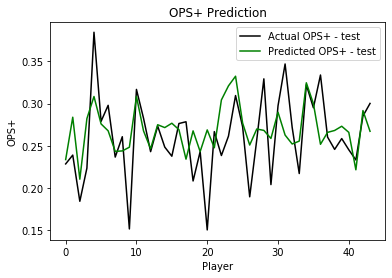

In [81]:
import matplotlib.pyplot as plt
plt.plot(y_test, color='black', label = 'Actual OPS+ - test')
plt.plot(y_test_pred, color='green', label = 'Predicted OPS+ - test')
plt.title('OPS+ Prediction')
plt.xlabel('Player')
plt.ylabel('OPS+')
plt.legend()
plt.show()

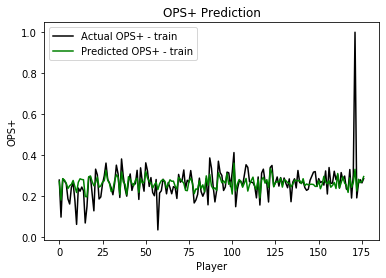

In [82]:
import matplotlib.pyplot as plt
plt.plot(y_train, color='black', label = 'Actual OPS+ - train')
plt.plot(y_train_pred, color='green', label = 'Predicted OPS+ - train')
plt.title('OPS+ Prediction')
plt.xlabel('Player')
plt.ylabel('OPS+')
plt.legend()
plt.show()